# Построение классификатора болезни Паркинсона по информации о нарисованных спиралях

### Все нужные импорты

In [335]:
import numpy as np
import pandas as pd
import os
import random 
from hashlib import md5
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

## Задание 1. Подготовка и анализ данных

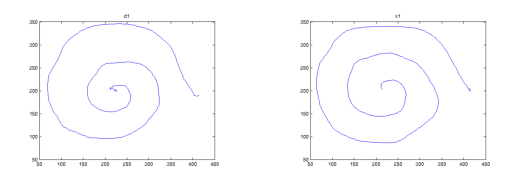

In [338]:
# Выводим пару рисунков

img1 = mpimg.imread("parkinson_dataset/hw_drawings/Dynamic Spiral Test/d1.png")
img2 = mpimg.imread("parkinson_dataset/hw_drawings/Static Spiral Test/s1.png")
# Создаем фигуры и оси для отображения изображений
fig, (ax1, ax2) = plt.subplots(1, 2)
# Отображаем первое изображение
ax1.imshow(img1)
ax1.axis('off')  # Убираем оси

# Отображаем второе изображение
ax2.imshow(img2)
ax2.axis('off')  # Убираем оси

# Показываем график
plt.show()

In [334]:
# Необходимые для обработки данных функции

# Класс для преобразования датафрейма в Датасет из последовательностей и разметки данных
class SequenceDataset(Dataset):
    def __init__(self, data, labels=None, seq_len=200):
        self.seq_len = seq_len
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data) // self.seq_len

    def __getitem__(self, idx):
        start_idx = idx * self.seq_len
        end_idx = start_idx + self.seq_len
        x = self.data[start_idx:end_idx]
        
        if self.labels is not None:
            y = self.labels[idx]
            return torch.tensor(x, dtype=torch.float), torch.tensor(y, dtype=torch.float)
        else:
            return torch.tensor(x, dtype=torch.float)

# Функция для преобразования датафрейма в Датасет из последовательностей временных шагов
def prepare_data(dataframe, seq_len=200):
    features = dataframe[['X', 'Y', 'Z', 'Pressure', 'GripAngle']].values
    labels = dataframe['Label'].values  # Предполагаю, что Label - это целевые значения
    
    dataset = SequenceDataset(features, labels, seq_len)
    return dataset

# Функция для загрузки данных из одного файла – на выходе имеем Датафрэйм
def load_data(patient_id, folder):
    filename = f"{folder}/{patient_id}.txt"
    df = pd.read_csv(filename, sep=';', names=column_names)
    
    # Добавляем метку "label" (0 - здоровый, 1 - больной)
    label = 0 if folder == path_to_control else 1
    df['Label'] = label
    df.drop('Timestamp', axis=1, inplace=True)
    df.drop('Test ID', axis=1, inplace=True)
    return df

# # One-hot encoding для Test ID
# def encode_to_list(value):
#     if value == 0:
#         return [1, 0, 0]
#     elif value == 1:
#         return [0, 1, 0]
#     else:
#         return [0, 0, 1]

In [319]:
# Вытягиваем данные из файлов
# Пути до папок и названия столбцов в датасетах 
path_to_control = 'parkinson_dataset/hw_dataset/control'
path_to_parkinson = 'parkinson_dataset/hw_dataset/parkinson'
column_names = ['X', 'Y', 'Z', 'Pressure', 'GripAngle', 'Timestamp', 'Test ID'] 



# Собираем номера пациентов (напр файл C_0001.txt - C_0001)
control_patients = []
control_filenames = os.listdir(path_to_control)
for filename in control_filenames:
    patient = filename.split('.txt')[0]
    control_patients.append(patient)
    
parkinson_patients = []
parkinson_filenames = os.listdir(path_to_parkinson)
for filename in parkinson_filenames:
    patient = filename.split('.txt')[0]
    parkinson_patients.append(patient)

# Загружаем все данные пациентов - получается список датафреймов по каждому пациенту
data_control = []
for patient in control_patients:
    dataset = prepare_data(load_data(patient, path_to_control))
    data_control.append(dataset)
    

data_parkinson = []
for patient in parkinson_patients:
    dataset = prepare_data(load_data(patient, path_to_parkinson))
    data_parkinson.append(dataset)

# for df in data_parkinson:
#     df['Test ID'] = df['Test ID'].apply(encode_to_list)
# for df in data_control:
#     df['Test ID'] = df['Test ID'].apply(encode_to_list)

# На выходе у нас получается список датасетов, в каждом из котором данные разделены на последовательности по 50 временных шагов

### Сразу разделяем на тестовые и тренировочные выборки 


In [320]:
# Пробуем вариант, при котором в тренировочной выборке будут варианты с максимальной длиной, а в тестовой - с минимальной

def get_min_len(list_of_datasets, repetitions):      # Функция сортирует и находит датасеты с минимальны количеством данных. 
    test_set = []                                    # Они отправляются в тестовую выборку, чтобы было больше данных для тренировки
    list_of_datasets.sort(key=len)
    for i in range(repetitions):
        test_set.append(list_of_datasets[0])
        del list_of_datasets[0]
    return test_set  

data_parkinson_test = get_min_len(data_parkinson, 5)
data_control_test = get_min_len(data_control, 3)

# Проверяем, что разделили 80/20
print(f'Пациентов с паркинсонизмом в тренировочном сете: {len(data_parkinson)}')
print(f'Здоровых пациентов в тренировочном сете: {len(data_control)}')
print(f'Пациентов с паркинсонизмом в тестовом сете: {len(data_parkinson_test)}')
print(f'Здоровых пациентов в тестовом сете: {len(data_control_test)}')
print('---'*20)

# Проверка на пересечение
intersection_exists = any(dataset in data_parkinson_test for dataset in data_parkinson) or any(dataset in data_control_test for dataset in data_control)

if intersection_exists:
    print("!!!! Данные списки пересекаются(")
else:
    print("Списки не пересекаются – все в кайфе")
print('---'*20)

# Объединение всех данных для тренировочной и тестовой выборки
all_data_train = data_control + data_parkinson
all_data_test = data_control_test + data_parkinson_test

# Создание объединенного набора данных
train_dataset = ConcatDataset(all_data_train)
test_dataset = ConcatDataset(all_data_test)

print(f"Тренировочный датасет содержит {len(train_dataset)} образцов")
print(f"Тестовый датасет содержит {len(test_dataset)} образцов")

Пациентов с паркинсонизмом в тренировочном сете: 20
Здоровых пациентов в тренировочном сете: 12
Пациентов с паркинсонизмом в тестовом сете: 5
Здоровых пациентов в тестовом сете: 3
------------------------------------------------------------
Списки не пересекаются – все в кайфе
------------------------------------------------------------
Тренировочный датасет содержит 1441 образцов
Тестовый датасет содержит 155 образцов


## Задание 2. Создание и обучение моделей нейронной сети

In [321]:
# LSTM модель (Long Short-Term Memory)

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=6, dropout=0.8):
        super(LSTMModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return out
        
# Для использования модели скопируйте строки ниже и вставьте в ячейке 'Обучение модели'

model = LSTMModel(input_dim=5, hidden_dim=256, output_dim=2, num_layers=6, dropout=0.8)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [25]:
# RNN простая

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)  # Выходной слой для бинарной классификации
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x имеет форму (batch_size, seq_len, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device=x.device)
        
        # Пропускаем последовательность через RNN
        out, _ = self.rnn(x, h0)
        
        # Берем последний временной шаг
        out = out[:, -1, :]
        
        # Пропускаем через линейный слой и сигмоиду
        out = self.fc(out)
        
        return out
        
# Для использования модели скопируйте строки ниже и вставьте в ячейке 'Обучение модели'

model = RNNModel(input_size=6, hidden_size=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [26]:
# GRU модель (Gated Recurrent Unit)

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)  # Выходной слой для бинарной классификации
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x имеет форму (batch_size, seq_len, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device=x.device)
        
        # Пропускаем последовательность через GRU
        out, _ = self.gru(x, h0)
        
        # Берем последний временной шаг
        out = out[:, -1, :]
        
        # Пропускаем через линейный слой и сигмоиду
        out = self.fc(out)
        
        return out

# Для использования модели скопируйте строки ниже и вставьте в ячейке 'Обучение модели'

model = GRUModel(input_size=6, hidden_size=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [54]:
# BiLSTM – двунаправленная LSTM
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.1, num_layers=2):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.dropout = dropout
        self.num_layers = num_layers
        
        self.bilstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=self.dropout if num_layers > 1 else 0
        )
        
        self.linear = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout_layer = nn.Dropout(dropout)

    def forward(self, x):
        lstm_out, _ = self.bilstm(x)
        last_hidden_state = lstm_out[:, -1, :]
        output = self.dropout_layer(last_hidden_state)
        logits = self.linear(output)
        return logits

# Для использования модели скопируйте строки ниже и вставьте в ячейке 'Обучение модели'

model = BiLSTMModel(input_dim=5, hidden_dim=256, output_dim=1, dropout=0.1, num_layers=2)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1.5]))
optimizer = optim.Adam(model.parameters(), lr=0.0001)

### Обучение модели
В ходе множества проделанных мною попыток (2 недели жизни убиты на этот проект) самую лучшую точность показала LSTM с данными параметрами

In [322]:
# Создаем загрузчик данных
dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True, drop_last=True)
print(f"Тotal batches: {len(dataloader)}")

# Сюда вставляйте параметры модели

model = LSTMModel(input_dim=5, hidden_dim=256, output_dim=2, num_layers=6, dropout=0.8)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

for epoch in range(10):
            correct = 0          # Для вычисления
            samples = 0          # потерь и точности 
            running_loss = 0.0   # в ходе обучения
            model.train()     # режим обучения
            for i, (x_batch, y_batch) in enumerate(dataloader):
                optimizer.zero_grad()  # Обнуляем оптимайзер
                outputs = model(x_batch) # Получаем выход модели
                probabilities = F.sigmoid(outputs)  # Применение сигмоидной активации для получения вероятностей
                loss = criterion(probabilities, y_batch.long())
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                predictions = probabilities.argmax(dim=1).unsqueeze(dim=1) # Получаем предсказания модели
                targets = y_batch.unsqueeze(dim=1)  # Приводим целевые значения к формату предсказаний модели
                correct += (predictions == targets).sum().item() # Считаем количество верно предсказанных
                samples += x_batch.size(0)                       # значений и общее число данных
            avg_loss = running_loss / len(dataloader)
            accuracy = correct / samples
            total_correct += correct
            total_samples += samples
            print(f'Epoch {epoch+1}: Accuracy: {correct/samples:.5f}, Loss: {avg_loss:.4f}')
print('Обучение прошло успешно! \nМодель сохранена в файл trained_model.pt')
        
# Сохраняем модель после окончания обучения
torch.save(model.state_dict(), 'trained_model.pt')

Тotal batches: 288
Epoch 1: Accuracy: 0.52153, Loss: 0.6827
Epoch 2: Accuracy: 0.63750, Loss: 0.6093
Epoch 3: Accuracy: 0.69722, Loss: 0.5759
Epoch 4: Accuracy: 0.74653, Loss: 0.5657
Epoch 5: Accuracy: 0.76875, Loss: 0.5602
Epoch 6: Accuracy: 0.77778, Loss: 0.5550
Epoch 7: Accuracy: 0.77986, Loss: 0.5482
Epoch 8: Accuracy: 0.77708, Loss: 0.5398
Epoch 9: Accuracy: 0.78125, Loss: 0.5328
Epoch 10: Accuracy: 0.78611, Loss: 0.5283


## Задание 3. Оценка качества модели

In [333]:
# Создание тестового загрузчика
test_dataloader = DataLoader(test_dataset, batch_size=5)

# Загрузка модели
loaded_model = LSTMModel(input_dim=5, hidden_dim=256, output_dim=2, num_layers=6, dropout=0.8)
loaded_model.load_state_dict(torch.load('trained_model.pt'))

# Вычисление метрик
total = 0
correct = 0
loaded_model.eval()  # Устанавливаем модель в режим оценки
with torch.no_grad():
    y_true_list = []   # Список истинных значений
    y_pred_scores = []  # Список вероятностей предсказанного класса
    y_pred_classes = []  # Список предсказанных классов
    
    for test_x_batch, test_y_batch in test_dataloader:
        test_outputs = loaded_model(test_x_batch)
        test_probabilities = torch.sigmoid(test_outputs)  # Вероятности
        probabilities_class_1 = test_probabilities[:, 1]  # Берем вероятности для класса 1 (если задача бинарной классификации)
        predicted_classes = test_probabilities.argmax(dim=1).unsqueeze(dim=1)  # Предсказываем класс через argmax
        target = test_y_batch.unsqueeze(dim=1)
        total += test_x_batch.size(0)
        correct += (predicted_classes == target).sum().item()
        y_true_list.extend(target.numpy())  # Сохраняем истинные значения
        y_pred_scores.extend(probabilities_class_1.detach().numpy())  # Сохраняем вероятности
        y_pred_classes.extend(predicted_classes.numpy())  # Сохраняем предсказанные классы
# Преобразуем списки в numpy массивы
y_true = np.array(y_true_list)
y_pred_scores = np.array(y_pred_scores)
y_pred_classes = np.array(y_pred_classes)

# Рассчитываем AUC-ROC
roc_auc = roc_auc_score(y_true, y_pred_scores)

# Построение Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Выводим результаты
print("Test Accuracy:", correct / total)
print("ROC-AUC Score:", roc_auc)

Test Accuracy: 0.9354838709677419
ROC-AUC Score: 0.9777815468113975


In [330]:
# Функция для построеная Confusion Matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(7, 7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.title(title)
    plt.show()

Normalized confusion matrix


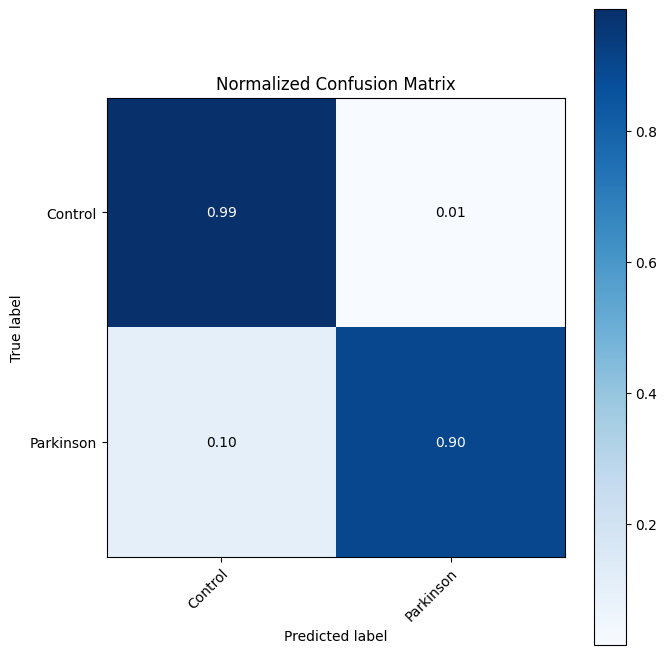

In [332]:
classes = ['Control', 'Parkinson']

plot_confusion_matrix(conf_matrix, classes, normalize=True, title='Normalized Confusion Matrix')